# Lesson 14.2 Batch Normalization在PyTorch中的实

## 一、nn.BatchNorm基本使用方法

### 1.nn.BatchNorm类介绍

nn.BatchNorm1d类主要用于处理2d数据，nn.BatchNorm2d则主要用来处理3d数据。简单来说，目前我们所使用的面板数据（二维表格数据）都属于2d数据，使用nn.BatchNorm1d处理即可。而后续在处理图像数据时，则需要视情况和使用nn.BatchNorm2d类。

首先我们解释其中三个核心参数：  
- `num_features`：输入数据的特征数量（假设为n），也就是前一层神经元数量或原始数据集特征数量，根据此前的论述，BN层最终构建的是一个n*n的对角矩阵，对角线元素包含$\gamma$，并且截距项为$\beta$；
- `eps`：方差分母修正项，为了防止分母为0；
- `affine`：是否进行仿射变换，需要注意的是，此时进行仿射变换时将使用无偏估计进行期望和方差的计算，并且初始条件下$\gamma=1，\beta=0$，当参数取值为True时，会显式设置$\gamma和\beta$参数并带入进行梯度下降迭代计算，取值为False时，参数不显示，实际的数据归一化过程就是对原数据进行无偏估计下的Z-Score变换。

In [1]:
# 查看帮助
nn.BatchNorm1d?

Init signature:
nn.BatchNorm1d(
    num_features: int,
    eps: float = 1e-05,
    momentum: float = 0.1,
    affine: bool = True,
    track_running_stats: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies Batch Normalization over a 2D or 3D input as described in the paper
`Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`__ .

.. math::

    y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

The mean and standard-deviation are calculated per-dimension over
the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
of size `C` (where `C` is the number of features or channels of the input). By default, the
elements of :math:`\gamma` are set to 1 and the elements of :math:`\beta` are set to 0. The
standard-deviation is calculated via the biased estimator, equivalent to `torch.var(input, unbiased=False)`.

Also by default, d

In [2]:
# 简单尝试
f = torch.arange(9).reshape(3, 3).float()
f

# 实例化一个BN类
bn1 = nn.BatchNorm1d(3)

bn1(f)

# Z-Score计算结果
(f - torch.mean(f, 0)) / torch.sqrt(torch.var(f, 0))

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [3]:
t = torch.tensor([1., 2])
t

tensor([1., 2.])

In [4]:
# 整体方差的无偏估计
torch.var(t)

tensor(0.5000)

In [5]:
torch.var(f, 0, unbiased=False)

tensor([6., 6., 6.])

In [6]:
# 样本方差计算结果
(f - torch.mean(f, 0)) / torch.sqrt(torch.var(f, 0, unbiased=False))

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]])

> 注，torch.var中可通过设置unbiased参数来进行样本方差计算

In [7]:
# 查看bn1的参数情况
list(bn1.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

据此也可确认在迭代开始之前，$\gamma和\beta$的初始值。同时，根据参数的可微性，我们也能看出其最终也是需要通过反向传播计算梯度，然后利用梯度下降进行求解的。

当然，此处如果我们将affine参数设置为False，则无法查看参数，并且归一化过程就是简单的在无偏估计下对数据进行Z-Score归一化。

In [8]:
bn2 = nn.BatchNorm1d(3, affine=False)

In [9]:
list(bn2.parameters())       # 此时无法查看bn2参数

[]

In [10]:
bn2(f)                       
# 处理后的数据也不是可微的，无法进行反向传播，因此也无法修改BN参数

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]])

- 训练数据均值与方差的迭代计算

  - 针对测试集计算的均值和方差就是真实计算出的训练数据的均值和方差，而不是一个估计的结果。

- nn.BatchNorm1d(3) 实例化
- 属性`.running_mean`
- `.running_var`

In [11]:
f = torch.arange(9).reshape(3, 3).float()
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [12]:
bn1 = nn.BatchNorm1d(3)  # 实例化


In [15]:
bn1.running_mean
bn1.running_var

tensor([0., 0., 0.])

tensor([1., 1., 1.])

In [16]:
bn1(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [18]:
f.mean(0)

tensor([3., 4., 5.])

In [19]:
bn1.running_mean

tensor([0.3000, 0.4000, 0.5000])

&emsp;&emsp;BN层在每一次进行归一化时，都会通过“某种”方法累计输入数据集的均值和方差，在每一次处理完一批数据之后，我们都可以通过调用BN层的running_mean和running_var查看BN层所累计的均值和方差结果：

In [21]:
bn1.running_mean
bn1.running_var

tensor([0.3000, 0.4000, 0.5000])

tensor([1.8000, 1.8000, 1.8000])

不过值得注意的是，BN层并不是记录输入数据集的均值和方差，而是采用了一种类似动量法的方法在累计每一个小批数据的统计量。这种累计过程如下：首先，当我们每次实例化一个BN层之后，都会获得一组原始的running_mean和running_var

In [23]:
bn2 = nn.BatchNorm1d(3)
bn2.running_mean
bn2.running_var

tensor([0., 0., 0.])

tensor([1., 1., 1.])

初始条件下，running_mean取值为0，running_var取值为1。而当我们在使用BN层进行每一次归一化数据时，BN层的running_mean和running_var将按照如下公式进行调整：
$$running\_mean = (1-momentum) * running\_mean + momentum * sample\_mean$$

$$running\_var = (1-momentum) * running\_var + momentum * sample\_var$$

&emsp;&emsp;其中，𝑚𝑜𝑚𝑒𝑛𝑡𝑢𝑚是BN层实例化过程中的可选参数，默认值为0.1，sample表示当前输入的小批数据。上述过程可简单理解为BN层每每次归一化一批数据，都会针对围绕已经记录的running_mean/var和小批数据的sample_mean/var进行加权求和，在momentum取值为0.1的情况下，原running_mean/var权重是sample_mean/var的九倍，也就是说，当前数据归一化完成后，running_mean/var会朝向sample_mean/var小幅移动。

例如，bn2迭代一轮（训练一批数据）后，bn2的running_mean/var取值结果如下：

In [24]:
bn2(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [25]:
bn2.running_mean
bn2.running_var

tensor([0.3000, 0.4000, 0.5000])

tensor([1.8000, 1.8000, 1.8000])

In [26]:
bn3 = nn.BatchNorm1d(3)

In [27]:
torch.mean(f, 0)

tensor([3., 4., 5.])

In [28]:
bn3.running_mean * 0.9 + 0.1 * torch.mean(f, 0)

tensor([0.3000, 0.4000, 0.5000])

In [29]:
bn3.running_var * 0.9 + 0.1 * torch.var(f, 0)

tensor([1.8000, 1.8000, 1.8000])

当然，在这种设置下，如果同一批数据，当迭代很多轮之后，running_mean/var就会最终取到sample_mean/var。

In [31]:
bn3 = nn.BatchNorm1d(3)

In [33]:
mean_l = []
var_l = []

for i in range(50):
    temp = bn3(f)
    mean_l.append(bn3.running_mean.clone().tolist())
    var_l.append(bn3.running_var.clone().tolist())

In [34]:
# 查看同一批数据迭代50轮之后BN层记录的统计量和数据真实统计量之间区别#

bn3.running_mean
torch.mean(f, 0)

tensor([2.9845, 3.9794, 4.9742])

tensor([3., 4., 5.])

In [35]:
bn3.running_var
torch.var(f, 0)

tensor([8.9588, 8.9588, 8.9588])

tensor([9., 9., 9.])

能够看出，已经非常接近了，当然，我们也可以通过绘制图像来可视化呈现BN层记录的统计量的变化情况。此处我们查看数据集第二列均值在BN层统计结果中的变化情况

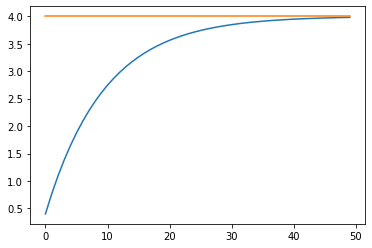

In [37]:
#————————————————————————————mean可视化————————————————————————————

mean_t = torch.tensor(mean_l)

plt.plot(range(50), mean_t[:, 1], torch.full_like(mean_t[:, 1], torch.mean(f, 0)[1]))

当然，如果是小批量输入数据，即每次输入原数据的一部分时，经过多轮epoch迭代，BN最终也将累计记录到整体均值和方差。

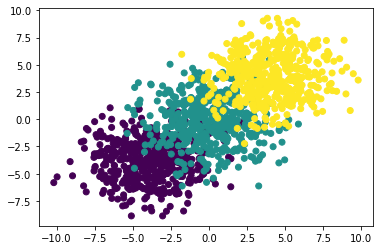

In [39]:
#————————————————————————————分类数据————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

features, labels = tensorGenCla()
plt.scatter(features[:, 0], features[:, 1], c = labels)

In [41]:
# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

train_loader.dataset[:]

(tensor([[ 4.1332e+00,  2.9771e+00],
         [ 3.0841e+00, -2.9221e+00],
         [ 6.2952e-01, -6.7642e-03],
         ...,
         [ 1.5481e+00,  4.7542e+00],
         [-5.0916e+00, -8.8707e+00],
         [-2.2565e+00, -3.2018e+00]]),
 tensor([[2],
         [1],
         [1],
         ...,
         [2],
         [0],
         [0]]))

In [42]:
# 训练集特征
features_train = train_loader.dataset[:][0]
features_train

tensor([[ 4.1332e+00,  2.9771e+00],
        [ 3.0841e+00, -2.9221e+00],
        [ 6.2952e-01, -6.7642e-03],
        ...,
        [ 1.5481e+00,  4.7542e+00],
        [-5.0916e+00, -8.8707e+00],
        [-2.2565e+00, -3.2018e+00]])

In [43]:
# 查看训练集特征的均值和方差
torch.mean(features_train, 0)
torch.var(features_train, 0)

tensor([0.1634, 0.0689])

tensor([15.0641, 14.1290])

In [44]:
# 实例化一个BN类
bn4 = nn.BatchNorm1d(2)

In [45]:
bn4.running_mean
bn4.running_var

tensor([0., 0.])

tensor([1., 1.])

In [46]:
# 打印一个批次的数据
for X, y in train_loader:
    print(X)
    break

tensor([[ 7.7108,  7.2302],
        [ 1.8754, -2.8959],
        [-6.2852, -2.2107],
        [-1.9569,  1.4654],
        [-4.6756, -5.5366],
        [-6.5001, -2.7485],
        [-5.5745, -4.3031],
        [-4.5702, -6.0784],
        [ 6.2697,  4.4720],
        [ 2.2679,  4.9896]])


In [48]:
# 悉心小批次数据归一化计算
for X,y in train_loader:
    temp = bn4(X)

In [49]:
bn4.running_mean
bn4.running_var

# 只遍历了一次数据，没有特别接近原始结果


tensor([-0.1321, -0.2786])

tensor([18.8896, 13.2366])

In [50]:
#————————————————————————————增加遍历次数————————————————————————————

# 实例化
bn4 = nn.BatchNorm1d(2)

bn4.running_mean
bn4.running_var

tensor([0., 0.])

tensor([1., 1.])

In [51]:
# 执行小批次数据归一化，遍历5次数据
torch.manual_seed(22)

for epochs in range(5):
    for X,y in train_loader:
        temp = bn4(X)

In [53]:
# 查看训练集特征的均值和方差
torch.mean(features_train, 0)
torch.var(features_train, 0)



tensor([0.1634, 0.0689])

tensor([15.0641, 14.1290])

In [52]:
bn4.running_mean
bn4.running_var

# BN记录结果朝向整体真实结果靠拢

tensor([ 0.0182, -0.1532])

tensor([15.6158, 13.7330])

- 迭代记录的原因
一是面对超大规模数据时候求解均值或方差可能无法直接进行求解，尤其是如果数据是分布式存储的话一次性求解均值和方差就会更加困难
二迭代计算是深度学习求解参数的基本过程，所有深度学习框架为了更好地满足迭代计算，都进行了许多精巧的设计，从而使得迭代计算更加高效和平稳，而在计算训练集整体均值时，如果借助神经网络向前传播的过程进行迭代记录，便能够在控制边际成本的情况下快速达成目标。

- momentum参数设置
  - 数据量较小，d

&emsp;&emsp;当每一个小批数据数据量比较小时，我们应该将历史数据比重调高，也就是降低momentum取值，以减少局部规律对获取总体规律的影响，当然，此时我们也需要增加遍历数据的次数epochs；而反之则可以考虑增大momentum取值。

- track_running_stats参数

&emsp;&emsp;对于BN来说，最后一个参数就是track_running_stats，默认取值为True。当此参数为True时，BN层会在每次迭代过程中会结合历史记录更新running_mean/var，当track_running_stats=False时，BN层将running_mean/var为None，并且在进行预测时会根据输入的小批数据进行均值和方差计算。在大多数情况下，并不推荐修改该参数的默认取值。

注意，迭代过程需要设置随机数种子，否则每一轮迭代都将创建不同的小批数据，也将影响最终BN层记录结果

In [54]:
# 两次调用train_loader，生成两类不同小批数据
for epochs in range(2):
    for X, y in train_loader:
        print(X)
        break
# 两次产生的数据不一样

tensor([[ 1.5059,  0.6382],
        [-1.1789,  1.9937],
        [-1.9199, -0.2509],
        [-3.4746, -4.9443],
        [-5.6430, -0.3518],
        [-2.0013, -6.8168],
        [ 2.1244,  5.0391],
        [ 2.9347,  1.9303],
        [-7.0042, -1.6217],
        [-3.3304, -2.1655]])
tensor([[-2.9819, -2.2951],
        [ 0.8349, -1.6188],
        [-6.9765, -6.8024],
        [ 1.4358, -6.1974],
        [-1.9199, -0.2509],
        [ 0.9648,  0.0188],
        [-1.9294,  2.7166],
        [ 1.3263,  4.7751],
        [-0.9331, -0.5933],
        [-1.3452, -3.6203]])


### 2.model.train()与model.eval()

- 伴随向前传播调整running_mean/var

BN层的running_mean/var是伴随向前传播同步调整的。也就是说，在track_running_stats开启时，只要进行一次向前传播，就会更新一次running_mean/var，这明显是不合适的。

但是我们也知道，只要要进行测试集的测试，就一定需要模型执行测试数据的向前传播以得出模型结果，此时应该怎么办呢？

- model.train()与model.eval()
  - `model.train()`表示开启模型训练模式，在默认情况下，我们实例化的每一个模型都是出于训练模式的
  - `model.eval()`则表示将模型转化为测试模式
  

In [55]:
bn5 = nn.BatchNorm1d(3) #实例化

In [56]:
bn5.train()  # 进入到训练模式

BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [57]:
bn5.train?

Signature: bn5.train(mode: bool = True) -> ~T
Docstring:
Sets the module in training mode.

This has any effect only on certain modules. See documentations of
particular modules for details of their behaviors in training/evaluation
mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
etc.

Args:
    mode (bool): whether to set training mode (``True``) or evaluation
                 mode (``False``). Default: ``True``.

Returns:
    Module: self
File:      c:\users\hp\python\python310\lib\site-packages\torch\nn\modules\module.py
Type:      method


In [58]:
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [60]:
# 进入训练模式
bn5 = nn.BatchNorm1d(3)
bn5.train()
bn5.running_mean
bn5.running_var

BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

tensor([0., 0., 0.])

tensor([1., 1., 1.])

In [61]:
bn5(f)                      # 对输入数据的统计量无偏估计

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [62]:
bn5.running_mean            # 并且更新记录的统计结果
bn5.running_var

tensor([0.3000, 0.4000, 0.5000])

tensor([1.8000, 1.8000, 1.8000])

In [63]:
#————————————————————————————重新实例化bn5————————————————————————————

bn5 = nn.BatchNorm1d(3)
bn5.eval()                 # 进入测试模式
bn5.running_mean
bn5.running_var

bn5(f)

# 不同于训练模式下的bn5(f)

BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

tensor([0., 0., 0.])

tensor([1., 1., 1.])

tensor([[0.0000, 1.0000, 2.0000],
        [3.0000, 4.0000, 5.0000],
        [6.0000, 7.0000, 8.0000]], grad_fn=<NativeBatchNormBackward0>)

注意该结果的解读，此时是以running_mean/var作为均值和方差对数据集进行归一化处理，并且，此时的$\gamma和\beta$分别是1和0。

In [64]:
list(bn5.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

因此最终处理结果还是原始数据本身。另外，在测试模式下，BN层也不会再记录running_mean/var。

In [65]:
bn5.running_mean
bn5.running_var

tensor([0., 0., 0.])

tensor([1., 1., 1.])

在训练模式下，BN处于另一种完全不同的行为模式。
.training属性来查看模型处于训练模式还是测试模式

## 二、利用nn.BatchNorm构建带BN的神经网络

BN本质上是一种自适应的数据分布调整算法，同时我们也知道，数据分布的调整并不影响，因此我们可以在任何需要的位置都进行BN归一化。

另外，根据Glorot条件，我们知道在模型构建过程中需要力求各梯度计算的有效性和平稳性，因此我们可以考虑在每一个线性层前面或者后面进行数据归一化处理。

实际模型构建过程中，在模型中添加BN层和添加线性层类似，我们只需要在自定义模型类的init方法中添加BN层，并在向前传播方法中确定BN层的调用方法即可。

- BN层一般放在激活层前，其实放在前后都行

而在具体BN层位置选择方面，是放在线性层前面还是放在线性层后面，目前业内没有定论，既没有理论论证BN层的最佳位置，也没有严谨的实验证明在哪个位置放置BN层效果最好。因此我们大可根据自己的习惯，以及自身经验的判断选择BN层的位置。当然，为了实验方便，我们会同时创建可以前置或者后置BN层的模型。（这里我们将放在隐藏层前面（也就是线性层后面）称为BN层前置，放在隐藏层后面称为BN层后置。）

### 1.构建模型类

我们创建一个同时能够调整激活函数、可选是否包含BN层、以及BN层放置位置的模型，当然，该模型仍然是分层创建，在包含了上述参数后相当于此前模型的一个集成。我们先从简单入手，创建一个两层神经网络、BN层可选、激活函数可选的模型。

In [66]:
class net_class1(nn.Module):
    def __init__(self,act_fun = torch.relu,in_features=2,n_hidden=4,out_features=1,bias=True,BN_model=None,momentum = 0.1):
        super(net_class1,self).__init__()
        self.linear1 = nn.Linear(in_features,n_hidden,bias=bias)
        self.normalize1 = nn.BatchNorm1d(n_hidden,momentum=momentum)
        self.linear2 = nn.Linear(n_hidden,out_features,bias=bias)
        # 添加两个属性
        self.BN_model = BN_model  # 是否对数据进行初始化
        self.act_fun = act_fun   # 激活函数

    def forward(self,x):
        if self.BN_model == None:  # 默认为None，不带BN层
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            out = self.linear2(p1)
        elif self.BN_model == 'pre':   # BN层在激活函数的前面
            z1 = self.normalize1(self.linear1(x))
            p1 = self.act_fun(z1)
            out = self.linear2(p1)
        elif self.BN_model == 'post':  # BN层在激活函数的后面
            z1 = self.linear1(x)
            p1 = self.act_fun(z1)
            out = self.linear2(self.normalize1(p1))
        return out
        


In [67]:
#————————————————————————————测试模型性能————————————————————————————

# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

In [68]:
# 实例化一个前置BN层的神经网络
import torch


torch.manual_seed(24)
relu_model1_norm = net_class1(BN_model='pre')
# 两层的前置BN层的神经网络,激活函数为relu


In [69]:
# 设置模型为训练模式
relu_model1_norm.train()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [70]:
# 将模块中的所有模块都设置为训练模型
list(relu_model1_norm.modules())

[net_class1(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (linear2): Linear(in_features=4, out_features=1, bias=True)
 ),
 Linear(in_features=2, out_features=4, bias=True),
 BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=4, out_features=1, bias=True)]

In [71]:
for m in list(relu_model1_norm.modules()):
    print(m.training == True)
# 所有的层 都被调整为训练模型

True
True
True
True


In [74]:
# 调整为测试模型
relu_model1_norm.eval()

for m in list(relu_model1_norm.modules()):
    print(m.training == True)

    

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

False
False
False
False


In [75]:
# 在调回训练模型
relu_model1_norm.train()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [80]:
list(relu_model1_norm.modules())
print('')


[net_class1(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (linear2): Linear(in_features=4, out_features=1, bias=True)
 ),
 Linear(in_features=2, out_features=4, bias=True),
 BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=4, out_features=1, bias=True)]

In [81]:
#——————————————————————————BN层的running_mean/var，BN层是模型的第二个模块—————————————————————————

list(relu_model1_norm.modules())[2]

BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [82]:
list(relu_model1_norm.modules())[2].running_mean
list(relu_model1_norm.modules())[2].running_var

tensor([0., 0., 0., 0.])

tensor([1., 1., 1., 1.])

In [ ]:
features

In [83]:
#————————————————————————————查看BN层的参数————————————————————————————
list(relu_model1_norm.modules())[2].weight
list(relu_model1_norm.modules())[2].bias

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)

In [94]:
#————————————————————————————训练模型————————————————————————————
# 进行模型训练，迭代三轮
fit(net=relu_model1_norm, 
    criterion=nn.MSELoss(), 
    optimizer=optim.SGD(relu_model1_norm.parameters(), lr = 0.03), 
    batchdata=train_loader, 
    epochs=20, 
    cla=False)


In [95]:
# BN层变化的结果
list(relu_model1_norm.modules())[2].weight
list(relu_model1_norm.modules())[2].bias

# weight,bias 确实发生了变化

Parameter containing:
tensor([1.0154, 1.3411, 1.4413, 1.1275], requires_grad=True)

Parameter containing:
tensor([-0.2582, -0.0237,  0.0671, -0.2542], requires_grad=True)

In [96]:
# 查看BN层的记录的统计指标
list(relu_model1_norm.modules())[2].running_mean
list(relu_model1_norm.modules())[2].running_var

# 从BN层的记录结果来看，隐藏层输入的数据基本是零均值的
# 从侧面也证明了BN调整效果的有效性

tensor([-0.1055, -0.2705, -0.1414,  0.0372])

tensor([0.1882, 0.4241, 0.6292, 0.3662])

In [97]:
# 模型设置为训练模型
relu_model1_norm.eval()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [98]:
mse_cal(train_loader,relu_model1_norm)   # 计算mse


tensor(0.2611, grad_fn=<MseLossBackward0>)

In [99]:
mse_cal(test_loader,relu_model1_norm)

tensor(0.4310, grad_fn=<MseLossBackward0>)

In [100]:
# running_mean和running_var的取值变化情况
list(relu_model1_norm.modules())[2].weight
list(relu_model1_norm.modules())[2].bias
list(relu_model1_norm.modules())[2].running_mean
list(relu_model1_norm.modules())[2].running_var

# 训练有效果，BN层训练生效

Parameter containing:
tensor([1.0154, 1.3411, 1.4413, 1.1275], requires_grad=True)

Parameter containing:
tensor([-0.2582, -0.0237,  0.0671, -0.2542], requires_grad=True)

tensor([-0.1055, -0.2705, -0.1414,  0.0372])

tensor([0.1882, 0.4241, 0.6292, 0.3662])

至此，我们就完成了带BN的模型从训练到测试的全流程。当然，为了方便后续直接使用带BN层或者其他需要灵活调整训练模式和测试模式的其他方法，我们将模型模式调整也集成到此前定义的model_train_test和model_comparison函数中。

In [101]:
def model_train_test(model, 
                     train_data,
                     test_data,
                     num_epochs = 20, 
                     criterion = nn.MSELoss(), 
                     optimizer = optim.SGD, 
                     lr = 0.03, 
                     init = False,
                     cla = False, 
                     eva = mse_cal):
    """模型误差测试函数：
    
    :param model_l：模型
    :param train_data：训练数据
    :param test_data: 测试数据   
    :param num_epochs：迭代轮数
    :param criterion: 损失函数
    :param lr: 学习率
    :param cla: 是否是分类模型
    :return：MSE列表
    """  
    # 模型评估指标矩阵
    train_l = []
    test_l = []
    # 模型训练过程
    for epochs in range(num_epochs):
        model.train()
        fit(net = model, 
            criterion = criterion, 
            optimizer = optimizer(model.parameters(), lr = lr), 
            batchdata = train_data, 
            epochs = epochs, 
            cla = cla)
        model.eval()
        train_l.append(eva(train_data, model).detach())
        test_l.append(eva(test_data, model).detach())
    return train_l, test_l

In [102]:
def model_comparison(model_l, 
                     name_l, 
                     train_data,
                     test_data,
                     num_epochs = 20, 
                     criterion = nn.MSELoss(), 
                     optimizer = optim.SGD, 
                     lr = 0.03, 
                     cla = False,
                     eva = mse_cal):
    """模型对比函数：
    
    :param model_l：模型序列
    :param name_l：模型名称序列
    :param train_data：训练数据
    :param test_data：测试数据    
    :param num_epochs：迭代轮数
    :param criterion: 损失函数
    :param lr: 学习率
    :param cla: 是否是分类模型
    :param eva: 模型评估指标
    :return：评估指标张量矩阵 
    """
    # 模型评估指标矩阵
    train_l = torch.zeros(len(model_l), num_epochs)
    test_l = torch.zeros(len(model_l), num_epochs)
    # 模型训练过程
    for epochs in range(num_epochs):
        for i, model in enumerate(model_l):
            model.train()
            fit(net = model, 
                criterion = criterion, 
                optimizer = optimizer(model.parameters(), lr = lr), 
                batchdata = train_data, 
                epochs = epochs, 
                cla = cla)
            model.eval()
            train_l[i][epochs] = eva(train_data, model).detach()
            test_l[i][epochs] = eva(test_data, model).detach()
    return train_l, test_l

### 2.带BN层的神经网络使用方法
&emsp;&emsp;接下来，我们简单尝试在自己生成的数据集上使用带BN层的模型。

In [103]:
#————————————————————————————生成数据————————————————————————————

# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

In [104]:
#————————————————————————————带BN层与不带BN层对比-训练模型————————————————————————————
# 激活函数为sigmoid函数 

# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
sigmoid_model1 = net_class1(act_fun= torch.sigmoid)    
sigmoid_model1_norm = net_class1(act_fun= torch.sigmoid, BN_model='pre')                                            
        
# 创建模型容器
model_l = [sigmoid_model1, sigmoid_model1_norm]           
name_l = ['sigmoid_model1', 'sigmoid_model1_norm']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_l, test_l = model_comparison(model_l = model_l, 
                                   name_l = name_l, 
                                   train_data = train_loader,
                                   test_data = test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

In [ ]:
# 训练误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

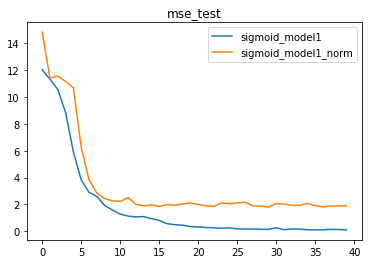

In [105]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test')

# 加入BN层之后，模型效果反而不如原始模型
# BN优化算法使用起来其实并不简单，并不是只要加入BN层模型效果就一定会有所提升